In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

from fem import plotmesh

# from jax.scipy.optimize import minimize
from scipy.optimize import minimize

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [2]:
# Do the FEM with jax-fem instead
def neohook_PK1(u_grad, params, dim):
    C10 = params
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([ [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    Cinv = jnp.linalg.inv(C)

    Psi1 = C10

    p = -C[2,2]*(2*Psi1)
    S = p*Cinv + 2*Psi1*jnp.eye(3)
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
neohook_PK1_vmap = vmap(neohook_PK1, in_axes=(0,0,None))
def neohook_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = neohook_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
neohook_sigma_vmap = vmap(neohook_sigma, in_axes=(0,0,None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: neohook_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [3]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist_nh = []
node_x_hist_nh = []
sigma_hist_nh = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)


    # GOH Material parameters
    r = np.sqrt((elem_X[:,0]-0.5)**2 + (elem_X[:,1]-0.5)**2)
    r = r/np.max(r)
    r_transition = 0.35
    s = 100 #controls (inversely) the smoothness of the transition. 
    sigmoid = 1/(1+np.exp(-s*(r-r_transition)))
    C10 = 0.5 + 0.2*sigmoid
    params = np.array(C10).reshape([-1,1,1])
    params_vec = jnp.repeat(params, axis=1, repeats=4)
    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = neohook_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_nh.append(F)
    node_x_hist_nh.append(node_x)
    sigma_hist_nh.append(sigma)
node_x_hist_nh = np.array(node_x_hist_nh)
F_hist_nh = np.array(F_hist_nh)
sigma_hist_nh = np.array(sigma_hist_nh)

[12-14 16:01:27][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-14 16:01:27][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-14 16:01:27][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-14 16:01:27][DEBUG] jax_fem: Done pre-computations, took 0.3706638813018799 [s]
[12-14 16:01:27][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-14 16:01:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-14 16:01:27][DEBUG] jax_fem: Start timing
[12-14 16:01:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-14 16:01:28][DEBUG] jax_fem: Function split_and_compute_cell took 1.0127 seconds
[12-14 16:01:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-14 16:01:29][DEBUG] jax_fem: Linear guess solve...
[12-14 16:01:29][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-14 16:01:29][DEBUG] jax_fem: PETSc 

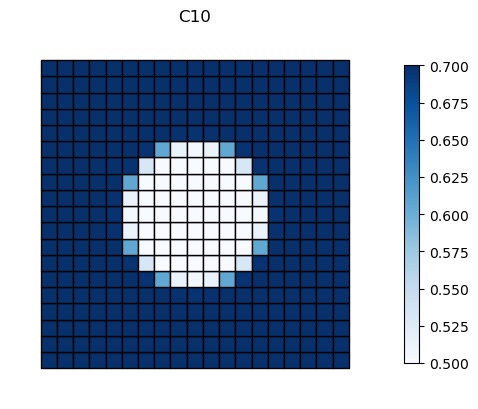

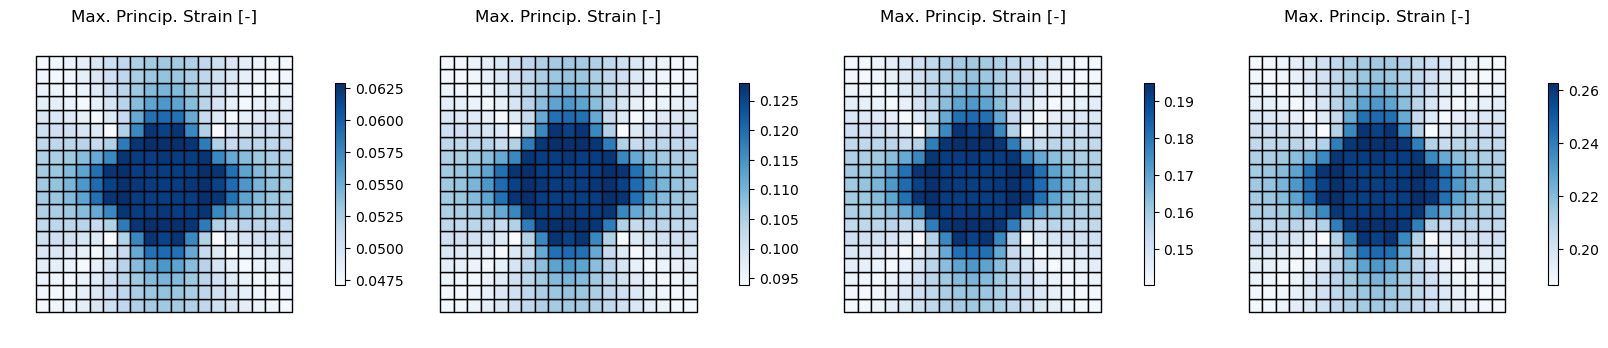

In [4]:
fig, ax = plt.subplots()
plotmesh(mesh.cells, mesh.points, C10, title='C10', ax=ax); 


fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_nh, F_hist_nh, sigma_hist_nh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [5]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(sigma_hist_nh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(sigma_hist_nh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(sigma_hist_nh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(sigma_hist_nh[:,bot_bd_elems,1,1], axis=1)
Fx = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Fy = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

In [6]:
def VF1(x,y,h,w,p):
    U_x = x**p/w**p
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF2(x,y,h,w,p):
    U_x = 0.0
    U_y = y**p/h**p
    return jnp.stack([U_x,U_y]).T

def VF3(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    U_y = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    return jnp.stack([U_x,U_y]).T

def VF4(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    U_y = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    return jnp.stack([U_x,U_y]).T

def VF5(x,y,h,w,p):
    U_x = 1.0-(x/w-1)**(2*p)
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF6(x,y,h,w,p):
    U_x = 0.0
    U_y = 1.0-(y/h-1)**(2*p)
    return jnp.stack([U_x,U_y]).T

def VF_and_grad(VF, x, y, h, w, p):
    VF_dx = jax.jacfwd(VF, argnums=0)
    VF_dy = jax.jacfwd(VF, argnums=1)
    VF_grad = vmap(lambda x,y,h,w,p: jnp.stack([VF_dx(x,y,h,w,p), VF_dy(x,y,h,w,p)]).T, in_axes=(0,0,None,None,None))

    VF_vmap = vmap(VF, in_axes=(0,0,None,None,None))
    return VF_vmap(x,y,h,w,p), VF_grad(x,y,h,w,p)


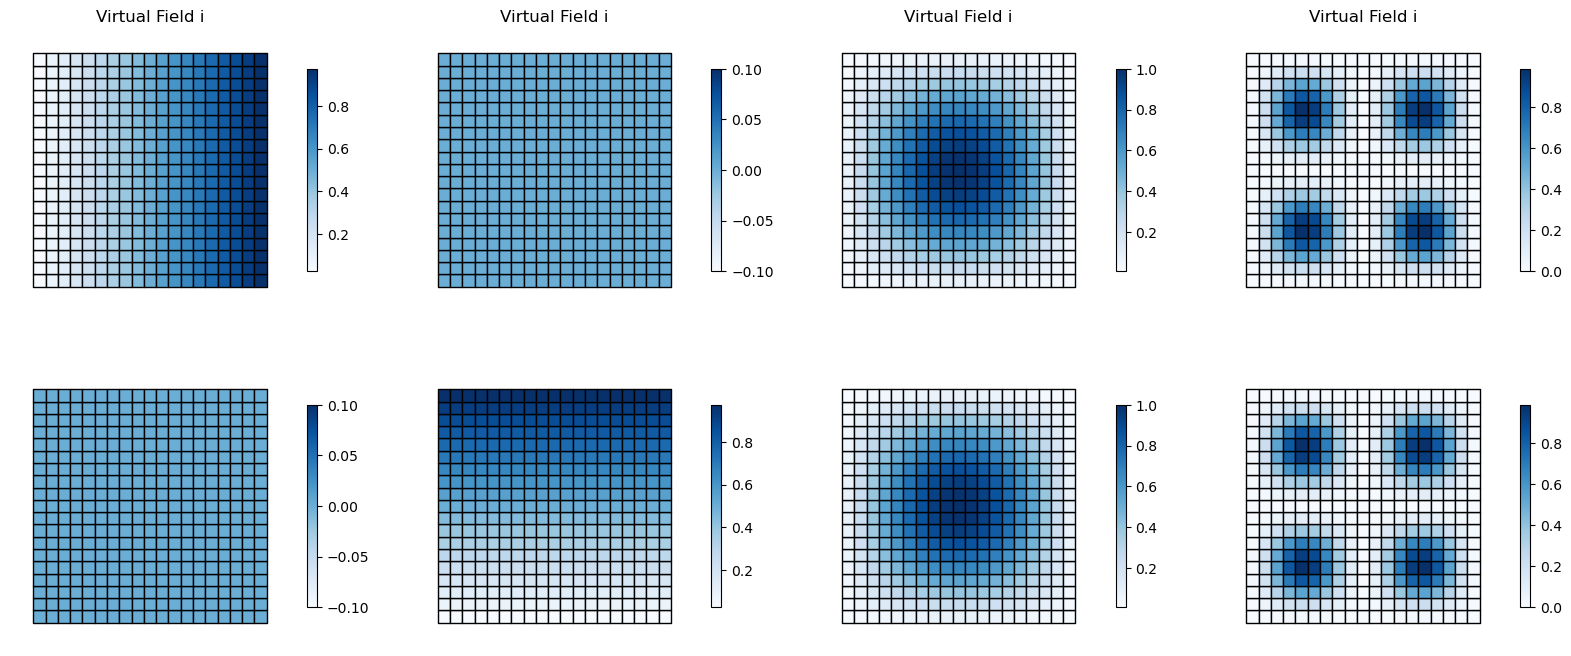

In [7]:
h = 1.0
w = 1.0
# VF_list = [VF1, VF1, VF2, VF2, VF3, VF4, VF5, VF6]
# p_list =  [1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0]
VF_list = [VF1, VF2, VF3, VF4]
p_list =  [1.0, 1.0, 1.0, 2.0]
x, y = elem_X.T
U, gradU = [], []
fig, axes = plt.subplots(2,len(VF_list),figsize=(len(VF_list)*5,8))
for ax, VF, p in zip(axes.T, VF_list, p_list):
    Ui, gradUi = VF_and_grad(VF, x,y,h,w,p)
    plotmesh(mesh.cells, mesh.points, Ui[:,0], title='Virtual Field i', ax=ax[0]); 
    plotmesh(mesh.cells, mesh.points, Ui[:,1], title=None, ax=ax[1]); 
    U.append(Ui)
    gradU.append(gradUi)
U, gradU = np.array(U), np.array(gradU)

In [14]:
#These are roughly the means of the gt params:
# C10 = -0.5
C10 = np.random.normal()
params = np.array(C10)
params = np.repeat(params, len(elem_X), axis=0)
@jit
def obj_fn(C10):
    loss = []
    for step in range(len(F_hist_nh)):
        F = F_hist_nh[step]
        u_grad = jnp.array(F - np.eye(2))
        # print(u_grad.shape, jnp.exp(C10).reshape([-1,1]).shape)
        P = neohook_PK1_vmap(u_grad, jnp.exp(C10), 2)
        P = P[:,:2,:2]
        W_int = []
        W_ext = []
        for i_vf in range(len(U)):
            W_int.append(jnp.einsum('ijk,ijk', P, gradU[i_vf]))

            idx_rgt_and_top = U.shape[1] - 1 #We use U such that U is constant at the boundary. Therefore sampling U at one point on the bd is enough.
            idx_lft_and_bot = 0
            W_ext_rgt_bd = U[i_vf, idx_rgt_and_top, 0]*Fx[step]*19 # + the non-constant component of U * Fy=0 because we assume no shear loads at the boundary, i.e. Fy|_rgt = 0.
            W_ext_top_bd = U[i_vf, idx_rgt_and_top, 1]*Fy[step]*19
            W_ext_lft_bd = U[i_vf, idx_lft_and_bot, 0]*Fx[step]*19
            W_ext_bot_bd = U[i_vf, idx_lft_and_bot, 1]*Fy[step]*19
            W_ext.append(W_ext_rgt_bd + W_ext_top_bd)
        W_int = jnp.array(W_int)
        W_ext = jnp.array(W_ext)
        loss.append(jnp.sum((W_int-W_ext)**2))
    
    return jnp.sum(jnp.array(loss))

In [16]:
#These are roughly the means of the gt params:
# C10 = -0.5
C10 = np.random.normal()
params = np.array(C10)
params = np.repeat(params, len(elem_X), axis=0)

def eval_W_int(P, gradU):
    return jnp.einsum('ijk,ijk', P, gradU)
def eval_W_ext(U, Fx, Fy):
    idx_rgt_and_top = U.shape[0] - 1
    idx_lft_and_bot = 0
    W_ext_rgt_bd = U[idx_rgt_and_top, 0]*Fx*19
    W_ext_top_bd = U[idx_rgt_and_top, 1]*Fy*19
    W_ext_lft_bd = U[idx_lft_and_bot, 0]*Fx*19
    W_ext_bot_bd = U[idx_lft_and_bot, 1]*Fy*19
    return W_ext_rgt_bd + W_ext_top_bd
@jit
def obj_fn(C10):
    loss = []
    for step in range(len(F_hist_nh)):
        F = F_hist_nh[step]
        u_grad = jnp.array(F - np.eye(2))
        # print(u_grad.shape, jnp.exp(C10).reshape([-1,1]).shape)
        P = neohook_PK1_vmap(u_grad, jnp.exp(C10), 2)
        P = P[:,:2,:2]
        W_int = []
        W_ext = []
        for i_vf in range(len(U)):
            W_int.append(eval_W_int(P,gradU[i_vf]))
            W_ext.append(eval_W_ext(U[i_vf], Fx[step], Fy[step]))
        W_int = jnp.array(W_int)
        W_ext = jnp.array(W_ext)
        loss.append(jnp.sum((W_int-W_ext)**2))
    
    return jnp.sum(jnp.array(loss))

In [17]:
print("Obj func with initial: ", obj_fn(params))
sol = minimize(obj_fn, jac = grad(obj_fn), x0=params, method='CG', options={'gtol':1.0})
params = jnp.exp(sol.x)
print("Obj func with final: ", obj_fn(sol.x))
# FSC: Do multiple restarts

Obj func with initial:  7957897.6212955415
Obj func with final:  848.9030356914398


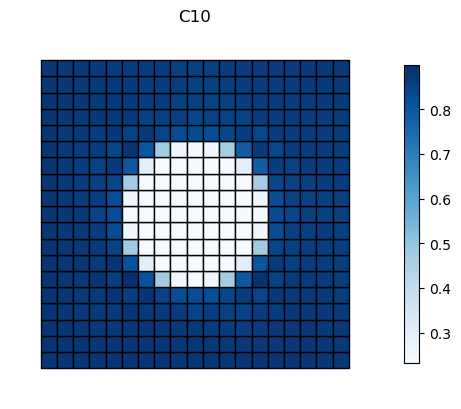

In [18]:
fig, ax = plt.subplots() 
plotmesh(mesh.cells, mesh.points, params, title='C10', ax=ax); 

In [11]:
params_vec = jnp.repeat(params.reshape([len(params),1,-1]), axis=1, repeats=4)

In [12]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
sigma_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = neohook_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    sigma_hist.append(sigma)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
sigma_hist = np.array(sigma_hist)

[12-14 16:02:02][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-14 16:02:02][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-14 16:02:02][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-14 16:02:02][DEBUG] jax_fem: Done pre-computations, took 0.0760350227355957 [s]
[12-14 16:02:02][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-14 16:02:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-14 16:02:02][DEBUG] jax_fem: Start timing
[12-14 16:02:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-14 16:02:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.8213 seconds
[12-14 16:02:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-14 16:02:03][DEBUG] jax_fem: Linear guess solve...
[12-14 16:02:03][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-14 16:02:03][DEBUG] jax_fem: PETSc 

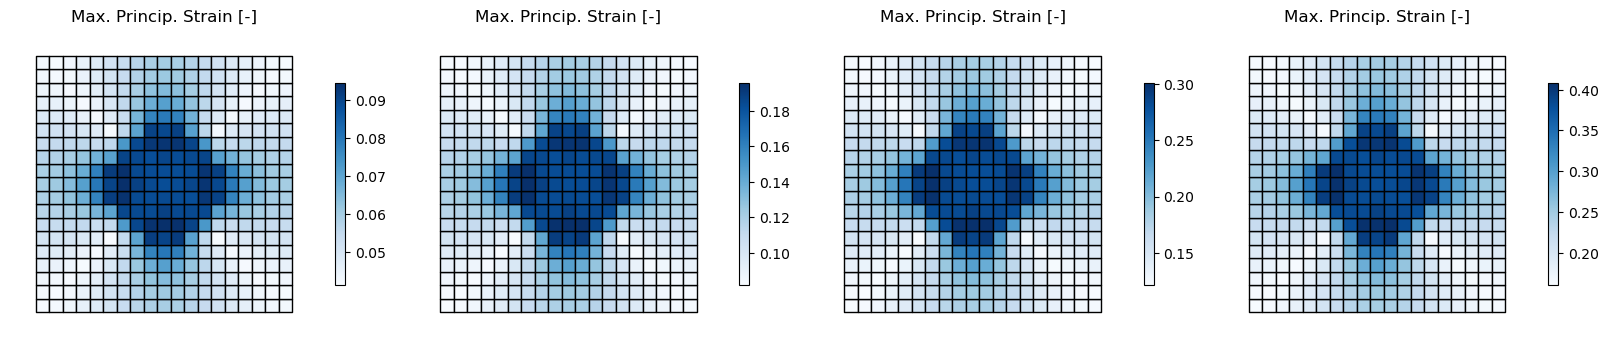

In [13]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 